$ \huge{Tarea \ 3: \ Deep \ Reinforcement \ Learning} $

En esta tarea utilizaremos la arquitectura de red "Dueling DQN" para poder aprender la mejor politica de acción del juego "Enduro" de "Atari".

$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $ 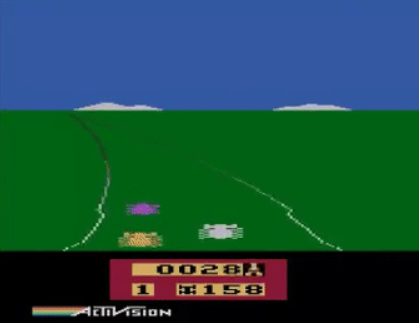

$ \huge{Parte \ 1: Implementaci \acute{o} n} $

## **Actividad 1:**

La razón por la que usamos los ultimos 4 estados del juego es porque así la red sabe como llegamos a ese estado y a partir de esta información puede determinar de mejor forma el paso siguiente. 

Ahora realizaremos todo el preprocesamiento a lo estados del juego.

# Enduro setup

### Roms Download

In [1]:
# Download Roms
!wget http://www.atarimania.com/roms/Roms.rar > /dev/null
# Decompresed files
!unrar e Roms.rar > /dev/null
!unzip 'ROMS.zip' > /dev/null
# Add Roms folder to atary_py PATH
!python -m atari_py.import_roms 'ROMS' > /dev/null

# > /dev/null omits command output

--2021-06-26 16:30:00--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   467KB/s    in 24s     

2021-06-26 16:30:25 (450 KB/s) - ‘Roms.rar’ saved [11128004/11128004]



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Gym environment

In [3]:
import gym
from gym import spaces
import cv2

def _process_frame84(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = frame[:155,10:]
    #x_t = cv2.resize(frame, (84, 84),  interpolation=cv2.INTER_LINEAR)
    x_t = cv2.resize(frame, (84, 84),interpolation=cv2.INTER_AREA)
    return x_t.astype(np.uint8)

class ProcessFrame84(gym.Wrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = spaces.Box(low=0, high=255, shape=(84, 84))

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return _process_frame84(obs), reward, done, info

    def reset(self):
        return _process_frame84(self.env.reset())

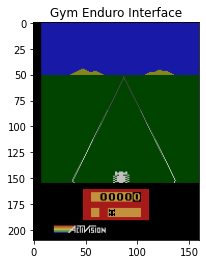

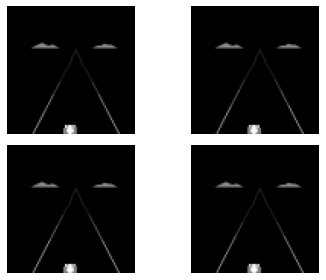

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from gym.wrappers import AtariPreprocessing
from gym.wrappers import FrameStack

#Create environment
game = 'Enduro-v0'
env = gym.make(game,frameskip=4)

# For reproducibility
seed = 7
env.seed(seed)

obs = env.reset()

plt.imshow(np.squeeze(obs))
plt.title('Gym Enduro Interface')
plt.show()

env = ProcessFrame84(env)
env = FrameStack(env,num_stack=4)
obs = env.reset()

for _ in range(100):
  action = random.randint(0, env.action_space.n-1)
  obs, reward, done, info = env.step(action)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.squeeze(np.array(obs)[0,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.squeeze(np.array(obs)[1,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.squeeze(np.array(obs)[2,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.squeeze(np.array(obs)[3,:,:]),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Replay buffer

In [5]:
import random
from collections import namedtuple

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [] # Can be a list a Deque or another type of list

    def push(self, *args):
        if len(self.memory) < self.capacity:
          self.memory.append(Transition(*args))
        else:
          self.memory.pop(0)
          self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## **Actividad 2:**

Ahora implementaremos la arquitectura Dueling DQN utilizando las 3 estrategias que se mencionan en la tarea.

# Dueling DQN Model

In [6]:
import torch
import torch.nn as nn
import numpy as np

class Dueling_DQN(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(Dueling_DQN, self).__init__()
        self.num_actions = num_actions
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)

        self.fc1_val = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc1_adv = nn.Linear(in_features=7*7*64, out_features=512)
        
        self.fc2_val = nn.Linear(in_features=512, out_features=1)
        self.fc2_adv = nn.Linear(in_features=512, out_features=num_actions)

        self.relu = nn.ReLU()

    def forward(self, x):
        # x es de (32, 4, 84, 84)
        batch_size = x.size(0)

        # TODO: forward pass red convolucional
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))

        # Capa flatten
        x = x.view(x.size(0), -1)
        
        # TODO: forward pass rama fully-connected para V(s)
        v_s = self.fc1_val(x)
        v_s = self.fc2_val(v_s)
        
        # TODO: forward pass rama fully-connected para A(s,a)
        a_sa = self.fc1_adv(x)
        a_sa = self.fc2_adv(a_sa)
        
        # TODO: Calculo de Q(s,a) a partir de ecuacion (4)
        # a_sa.mean(1) <- saca promedio por observacion
        # a_sa.mean(1).unsqueeze(1) <- transformamos a tensor de 1 columna
        # a_sa.mean(1).unsqueeze(1).expand(x.size(0), self.num_actions) <- Expandimos el musmo numero en x.size(0) filas, self.num_actions columnas
        Q_values = v_s + a_sa - a_sa.mean(1).unsqueeze(1).expand(x.size(0), self.num_actions)

        return Q_values

# Training

In [7]:
!pip install learn

  Created wheel for learn: filename=learn-1.0.0-cp37-none-any.whl size=1257 sha256=35230fa43ab2481884b965824b33f0ef9fcab725873b5565cb7224bf72c37568
  Stored in directory: /root/.cache/pip/wheels/6f/56/b3/1f3e9fa751e29dafe1a185798edd5fabe13e046238d64b695d
Successfully built learn


In [8]:
class LinearSchedule(object):
    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):
        self.schedule_timesteps = schedule_timesteps
        self.final_p            = final_p
        self.initial_p          = initial_p

    def value(self, t):
        """See Schedule.value"""
        fraction  = min(float(t) / self.schedule_timesteps, 1.0)
        return self.initial_p + fraction * (self.final_p - self.initial_p)

In [9]:
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
import os
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

replay_buffer_size=200_000
batch_size = 32
exploration = LinearSchedule(1_000_000, 0.1)
gamma = 0.99 # Discounted return
learning_starts = 50_000 # Paso en que se comienza a utilizar la red para escoger acciones (siguiendo política e-greedy)
learning_freq = 4 # Frecuencia de pasos en que se ejecuta una propagación error (loss) en la red
frame_history_len = 4 # Cantidad de frames de cada estado (definido en el pre-procesamiento)
target_update_freq=10_000 # Frecuencia en que se actualizan los pesos de la red target
LR = 0.00025 # Tasa de aprendizaje

in_channels = frame_history_len
input_shape = (84,84)
num_actions = env.action_space.n

# define Q target and Q 
Q = Dueling_DQN(in_channels, num_actions).to(device)
Q_target = Dueling_DQN(in_channels, num_actions).to(device)

# Optimizador, pueden elegir entre Adam o RMSProp
optimizer = optim.Adam(Q.parameters(), lr=LR)

# Criterio de pérdida
loss_criterion = torch.nn.MSELoss()

# Creamos nuestra memoria de estados
replay_memory = ReplayMemory(replay_buffer_size)

LOG_EVERY_N_STEPS = 50_000 # (Opcional) Frecuencia en la que se muestran resultados en consola
STEPS_PER_EPOCH = 250_000 # Pasos por época
N_EPOCHS = 20 # Número de épocas
SAVE_MODEL_EVERY_N_STEPS = 2
num_param_updates = 0

In [10]:
# Load checkpoint

score_x_episode = []
mean_score_epoch = []
max_score_epoch = []
loss_epoch = []
epochs = []

# Reseteamos nuestro ambiente para empezar el entrenamiento
last_obs = env.reset()

In [11]:
# Cargando modelos

my_path = 'drive/MyDrive/DeepLearningUC/Tarea3/Checkpoints'

if not os.path.exists(my_path):
  start_epoch = 1
else:
  # Cargamos el modelo Q y actualizamos Q_target
  nombre_Q = 'duelingDQN'
  model_file = os.path.join(my_path, nombre_Q)
  Q.load_state_dict(torch.load(model_file))
  Q_target.load_state_dict(Q.state_dict())

  # Cargamos checkpoints
  nombre_chp = 'chekpoints'
  file_name = os.path.join(my_path, nombre_chp)
  infile = open(file_name, 'rb')
  checkpoints = pickle.load(infile)
  infile.close()

  score_x_episode = checkpoints['score_x_episode']
  mean_score_epoch = checkpoints['mean_score_epoch']
  max_score_epoch = checkpoints['max_score_epoch']
  loss_epoch = checkpoints['loss_epoch']
  epochs = checkpoints['epochs']
  replay_memory = checkpoints['replay_memory']

  start_epoch = epochs[-1] + 1

In [ ]:
score_acum = 0

for epoch in tqdm(range(start_epoch, N_EPOCHS+1),position=0,leave=True):

  print("\n")
  print("Epoca: ", epoch)
  print("\n")

  for t in tqdm(range(STEPS_PER_EPOCH),position=0,leave=True):
      #1. before learning starts, choose actions randomly
      if t < learning_starts and epoch == 1:
          action = np.random.randint(num_actions)
      else:
          # epsilon greedy exploration
          sample = random.random()
          threshold = exploration.value(t + (epoch-1)*STEPS_PER_EPOCH)

          if sample > threshold:
              with torch.no_grad():
                # Calculo de la acción con la red Q
                observation = np.array(last_obs, dtype = np.float32) / 255.0
                observation = torch.from_numpy(observation).unsqueeze(0)
                Q_value_all_actions = Q(observation.cuda())
                action = int(((Q_value_all_actions).data.max(1)[1])[0])
          else:
              action = np.random.randint(num_actions)

      obs, reward, done, info = env.step(action)

      reward = np.clip(reward, -1.0, 1.0)
      score_acum = max(score_acum + reward, 0)

      replay_memory.push(last_obs, action, obs, reward, done)

      if done:
          obs = env.reset()
          score_x_episode.append(score_acum)
          score_acum = 0

      # update last_obs
      last_obs = obs

      ### 2. Perform experience replay and train the network.
      if (t >= learning_starts or epoch != 1) and (t % learning_freq == 0):
          obs_t = []
          act_t = []
          rew_t = []
          next_obs = []
          done_mask = []

          for elem in replay_memory.sample(batch_size):
            obs_t.append(elem.state)
            act_t.append(elem.action)
            rew_t.append(elem.reward)
            next_obs.append(elem.next_state)
            done_mask.append(elem.done)
          
          # Pasar los arreglos a tensores y al device actual
          # No olviden normalizar sus tensores de entrada
          obs_t = torch.from_numpy(np.array(obs_t, dtype = np.float32) / 255.0)
          act_t = torch.from_numpy(np.array(act_t))
          rew_t = torch.from_numpy(np.array(rew_t, dtype = np.float32))
          next_obs = torch.from_numpy(np.array(next_obs, dtype = np.float32) / 255.0)
          done_mask = torch.from_numpy(np.array(done_mask))

          # Pasamos de Bool a Int
          done_mask = torch.gt(done_mask, 0).int()

          obs_t = obs_t.cuda()
          act_t = act_t.cuda()
          rew_t = rew_t.cuda()
          next_obs = next_obs.cuda()
          done_mask = done_mask.cuda()

          # input batches to networks
          # Current Q
          curr_Q = Q(obs_t).gather(1, act_t.unsqueeze(1))
          curr_Q = curr_Q.squeeze()

          # Expected Q
          next_Q = Q_target(next_obs).detach()
          max_next_Q = torch.max(next_Q, 1)[0]
          expected_Q = rew_t + (1 - done_mask) * gamma * max_next_Q

          # Loss calculation
          loss = loss_criterion(curr_Q, expected_Q)

          # backwards pass
          optimizer.zero_grad()

          loss.backward()
          
          # update
          optimizer.step()
          num_param_updates += 1

          # Actualizar pesos de red target (cada target_update_freq actualizaciones de los parámetros de Q)
          if num_param_updates % target_update_freq == 0:
              Q_target.load_state_dict(Q.state_dict())
          
      if t % LOG_EVERY_N_STEPS == 0 or t == STEPS_PER_EPOCH - 1:
          if t == 0:
            pass
          elif len(score_x_episode) < 100:
              print('  --> Promedio ultimos 100 scores: {}  |  Max score: {}\n'.format(np.mean(score_x_episode), np.max(score_x_episode)))
          else:
              print('  --> Promedio ultimos 100 scores: {}  |  Max score: {}\n'.format(np.mean(score_x_episode[-100:]), np.max(score_x_episode[-100:])))
      
      if t == STEPS_PER_EPOCH-1:
        if len(score_x_episode) < 100:
          mean_score_epoch.append(np.mean(score_x_episode))
        else:
          mean_score_epoch.append(np.mean(score_x_episode[-100:]))
      
        max_score_epoch.append(np.max(score_x_episode))
        loss_epoch.append(loss.item())
        epochs.append(epoch)

  if epoch % SAVE_MODEL_EVERY_N_STEPS == 0:

      print("\n")
      print("Guardando los datos...")
      print("\n")

      my_path = 'drive/MyDrive/DeepLearningUC/Tarea3/Checkpoints'

      if not os.path.exists(my_path):
          os.makedirs(my_path)

      # Guardamos Q
      nombre_Q = 'duelingDQN'
      model_file = os.path.join(my_path, nombre_Q)
      torch.save(Q.state_dict(), model_file)

      # Guardamos checkpoints
      checkpoints_to_save = {"score_x_episode": score_x_episode,
                             "mean_score_epoch": mean_score_epoch,
                             "max_score_epoch": max_score_epoch,
                             "loss_epoch": loss_epoch,
                             "epochs": epochs,
                             'replay_memory': replay_memory}

      nombre_chp = 'chekpoints'
      file_name = os.path.join(my_path, nombre_chp)
      outfile = open(file_name,'wb')
      pickle.dump(checkpoints_to_save, outfile)
      outfile.close()

  0%|          | 0/250000 [00:00<?, ?it/s]



Epoca:  18




 20%|██        | 50037/250000 [04:22<17:56, 185.72it/s]

  --> Promedio ultimos 100 scores: 391.16  |  Max score: 490.0



 40%|████      | 100021/250000 [08:45<13:22, 186.94it/s]

  --> Promedio ultimos 100 scores: 394.01  |  Max score: 608.0



 60%|██████    | 150029/250000 [13:09<08:44, 190.63it/s]

  --> Promedio ultimos 100 scores: 398.62  |  Max score: 704.0



 80%|████████  | 200025/250000 [17:35<04:32, 183.37it/s]

  --> Promedio ultimos 100 scores: 406.77  |  Max score: 704.0



100%|██████████| 250000/250000 [22:00<00:00, 189.39it/s]


  --> Promedio ultimos 100 scores: 405.61  |  Max score: 704.0



Guardando los datos...




  0%|          | 17/250000 [00:00<27:39, 150.59it/s]



Epoca:  19




 20%|██        | 50025/250000 [04:30<17:39, 188.71it/s]

  --> Promedio ultimos 100 scores: 408.26  |  Max score: 704.0



 40%|████      | 100025/250000 [08:56<13:34, 184.09it/s]

  --> Promedio ultimos 100 scores: 406.02  |  Max score: 704.0



 60%|██████    | 150033/250000 [13:21<08:46, 189.88it/s]

  --> Promedio ultimos 100 scores: 402.67  |  Max score: 704.0



 80%|████████  | 200029/250000 [17:44<04:19, 192.91it/s]

  --> Promedio ultimos 100 scores: 395.05  |  Max score: 704.0



  0%|          | 17/250000 [00:00<24:38, 169.13it/s]

  --> Promedio ultimos 100 scores: 394.8  |  Max score: 704.0



Epoca:  20




 20%|██        | 50034/250000 [04:23<16:58, 196.40it/s]

  --> Promedio ultimos 100 scores: 391.22  |  Max score: 704.0



 40%|████      | 100025/250000 [08:46<13:07, 190.45it/s]

  --> Promedio ultimos 100 scores: 394.31  |  Max score: 704.0



 60%|██████    | 150030/250000 [13:07<08:45, 190.37it/s]

  --> Promedio ultimos 100 scores: 393.4  |  Max score: 704.0



 80%|████████  | 200037/250000 [17:39<04:29, 185.06it/s]

  --> Promedio ultimos 100 scores: 395.31  |  Max score: 704.0



100%|██████████| 250000/250000 [22:06<00:00, 188.40it/s]


  --> Promedio ultimos 100 scores: 392.02  |  Max score: 704.0



Guardando los datos...




100%|██████████| 3/3 [1:06:48<00:00, 1336.25s/it]


$ \huge{Parte \ 2: Detalles \ de \ implementaci \acute{o} n} $

## **Actividad 3:**

El principal beneficio de utilizar la arquitectura "Dueling DQN" comparada con la arquitectura original de "DQN" para estimar el valor de $ Q(s,a)$ es **generalizar el aprendizaje a través de acciones** sin imponer **ningún cambio** al aprendizaje por refuerzo. Por otro lado, la arquitectura de "Dueling DQN" separa claramente a la parte de $Q(s,a) $ que solo depende del estado ($V(s)$) y la que depende también de la accion a tomar a través de la ventaja $(A(s,a))$.  \\

Esto se puede ver más claramente viendo la forma en que se define la función $ Q(s,a) $ para ambos casos. \\

$ \ $ \\

$ \underline{DQN \ normal:} $

$ \ $  \\

$ Q(s,a) = r(s,a) + \gamma \cdot V^{*} (s', a') $

$ \ $ \\

$ \underline{Dueling \ DQN:} $

$ \ $  \\

$ Q(s,a) = V(s) + \left( A(s,a) - \cfrac{1}{|\mathcal{A}|} \sum_{a' \in \mathcal{A}} A(s,a') \right) $

$ \ $ \\


Esto se beneficio **se traduce en la experiencia de juego de enduro de la siguiente manera**:

Dado un estado cualquiera 's', siempre tendremos $V(s)$ sin importar la acción que tomemos. Por otro lado, notemos que si tenemos dos acciones $a_1$ y $a_2$ que son las optimas, es decir que:

1. $ A(s,a_1) - \cfrac{1}{|\mathcal{A}|} \sum_{a' \in \mathcal{A}} A(s,a')  = 0 $

2. $ A(s,a_2) - \cfrac{1}{|\mathcal{A}|} \sum_{a' \in \mathcal{A}} A(s,a') = 0 $

Entonces:

$ Q(s, a_1) = V(s) $ \\

$ Q(s, a_2) = V(s) $ \\

De esta forma, esto nos dice que la arquitectura de "Dueling DQN" contempla que pueden existir dos (o más) acciones optimas a tomar dado un estado y esto tiene **todo el sentido del mundo** pensando en que por ejemplo si el agente esta detrás de un auto, entonces son "igual de buenas" las decisiones de adelantar el auto de adelante por la derecha o por la izquierda. 

Otro enfoque para ver el beneficio en la experiencia del usuario es que como para toda acción optima $a'$ ocurre que $Q(s,a') = V(s)$ entonces **todo se reduce a que estados son los optimos o no** y los estados que uno claramente desecharía son aquellos en los que la colisión contra otro auto sea inminente.

## **Actividad 4:**

Las ventajas de utilizar un buffer de memoria para los estados de juego son:

1. La reproducción de experiencia aumenta la **eficiencia de los datos** a través de la reutilización de muestras en multiples actualizaciones.
2. **Reduce la correlación** entre las muestras utilizadas en la actualización de pesos en el aprendizaje.


La estrategía de exploración $ \epsilon - greedy \ $ parte con un valor grande para que así al principio la mayoría de las acciones tomadas sean aleatorias, es decir, tenemos una **exploración aleatoria** y a medida que va avanzando el aprendizaje, las **acciones tomadas por la red propiamente tal** vayan aumentando y así la red también vaya aprendiendo constantemente.

## **Actividad 5:**

Primero que todo para poder determinar el numero de parametros entrenables de un modelo implementaremos la siguiente función.

In [12]:
def num_trainable_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
num_dueling_DQN = num_trainable_parameters(Q)

In [14]:
num_dueling_DQN

3295402

**Número de parametros Dueling DQN:** 3.295.402

Ahora para comparar este número de parametros con el DQN original primero implementaremos el DQN original.

In [15]:
import torch
import torch.nn as nn
import numpy as np

class DQN_Original(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(DQN_Original, self).__init__()
        self.num_actions = num_actions
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)

        self.fc1 = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_actions)

        self.relu = nn.ReLU()

    def forward(self, x):
        # x es de (32, 4, 84, 84)
        batch_size = x.size(0)

        # TODO: forward pass red convolucional
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))

        # Capa flatten
        x = x.view(x.size(0), -1)
        
        # TODO: forward pass rama fully-connected para V(s)
        x = self.fc1(x)
        x = self.fc2(x) 

        return x

In [16]:
Q_original = DQN_Original(in_channels, num_actions).to(device)

In [17]:
num_DQN_original = num_trainable_parameters(Q_original)

In [18]:
num_DQN_original

1688745

**Número de parametros DQN original:** 1.688.745

Ahora calcularemos la diferencia de parametros y la proporción de parametros. 

In [20]:
dif = num_dueling_DQN - num_DQN_original

In [21]:
prop = num_dueling_DQN/num_DQN_original

In [22]:
dif

1606657

In [23]:
prop

1.951391121809391

Así tenemos que:

$ \ $ \\

**Diferencia de parametros:** 1.606.657

**Proproción de parametros dueling_DQN/DQN_original:** 1,95.


$ \ $ \\

De esta forma es facil notar que el modelo "Dueling_DQN" tiene casi el doble de parametros entrenables que "DQN_original".

## **Actividad 6:**

**Hiperparametros utilizados**

$ \ $ \\

$ \underline{Tamano \ \ de \ \ buffer:} $ 200.000 $ \ $ \\

$ \underline{Batch \ \ size:} $ 32 $ \ $ \\

$ \underline{Gamma:} $ 0,99  $ \ $ \\

$ \underline{Paso \ \  en \ \ el \ \ que \ \ comienza \ \ a \ \ aprender \ \ la \ \ red:} $ 50.000 $ \ $ \\

$ \underline{Frencuencia \ \ de \ \ pasos \ \ que \ \ aprende:} $ 4 $ \ $ \\

$ \underline{Frencuencia \ \ en \ \ que \ \ se \ \ actualizan \ \ los \ \ pesos \ \ de \ \ la \ \ red \ \ target:} $ 10.000 $ \ $ \\

$ \underline{Learning \ \ rate:} $ 0,00025 $ \ $ \\

$ \underline{Pasos \ \ por \ \ epoca:} $ 250.000 $ \ $ \\

$ \underline{Numero \ \ de \ \ epocas:} $ 20 $ \ $ \\

$ \underline{Frecuencia \ \ de \ \ pasos \ \ que \ \ se \ \ imprimen \ \ resultados:} $ 50.000 $ \ $ \\

$ \underline{Frecuencia \ \ de \ \ epocas \ \ que \ \ se \ \ guarda \ \ el \ \ modelo:} $ 2 $ \ $ \\

$ \underline{Optimizador:} $ Adam $ \ $ \\

$ \underline{Funci \acute{o} n \ \ de \ \ perdida: } $ Cuadratica


## **Actividad 7:**

Ahora realizaremos los graficos correspondientes a la evolución del "score promedio", "mejor score" y la "perdida". 

**Evolución del score promedio**

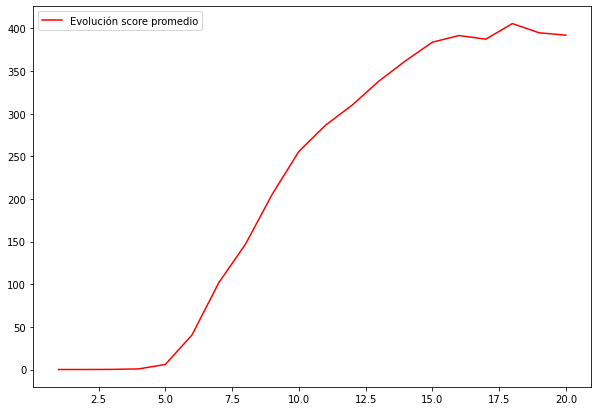

In [25]:
# Graficar el score promedio

plt.figure(figsize=(10,7))

plt.plot(epochs, mean_score_epoch, color = "red")

plt.legend(['Evolución score promedio'], loc='upper left')

plt.show()

$ \underline{Comentarios:} $ Notemos que el score promedio va aumentando de manera rapida y constante hasta llegar a un score promedio de aproximadamente $400$, lo cual es muy bueno y por esto podemos concluir que nuestra red esta bien implementada y además aprende de manera optima.

**Evolución del mejor score**

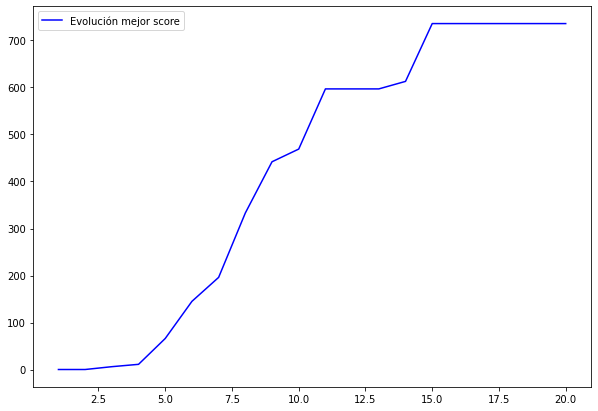

In [ ]:
# Graficar el maximo score

plt.figure(figsize=(10,7))

plt.plot(epochs, max_score_epoch, color = "blue")

plt.legend(['Evolución mejor score'], loc='upper left')

plt.show()

$ \underline{Comentarios:} $ Notemos que el mejor score va aumentando de manera rapida y constante hasta llegar a un score de aproximadamente $700$, lo cual es muy bueno y por esto y sumado a la evolución del score promedio podemos concluir que nuestra red esta bien implementada y además aprende de manera optima.

**Evolución de la perdida**

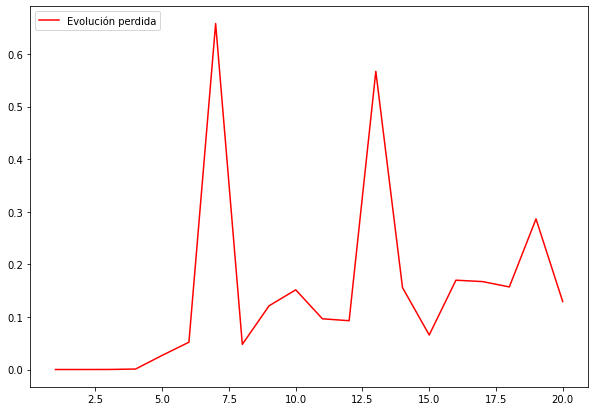

In [ ]:
# Graficar los perdidas

plt.figure(figsize=(10,7))

plt.plot(epochs, loss_epoch, color = "red")

plt.legend(['Evolución perdida'], loc='upper left')

plt.show()

$ \underline{Comentarios:} $ Notemos que la perdida a ratos va acumentando y luego decreciendo (sin embargo, siempre mantenido valores menores a 1). La razón de esto es porque la red "Q" y la red "Q_target" tienen diferentes pesos y cuando se copian los pesos disminuye la perdida y después va aumentando la perdida a medida que se van ajustando los targets dinamicos.

#Testing

Ahora lo que haremos será testear nuestro modelo para mostrar como aprendio nuestra red través de las imagenes de una partida.

In [ ]:
frames = []

obs = env.reset()
frames.append(np.squeeze(np.array(obs)[0,:,:]))


for i in range(1_000):
  observation = np.array(obs, dtype= np.float32) / 255.0
  observation = torch.from_numpy(observation).unsqueeze(0)

  Q_value_all_actions = Q(observation.cuda())
  action = int(((Q_value_all_actions).data.max(1)[1])[0])

  obs, reward, done, _ = env.step(action)

  frames.append(np.squeeze(np.array(obs)[0,:,:]))


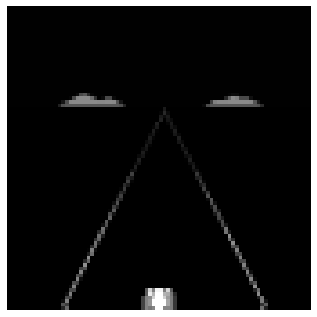

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

frames_show = frames

plt.figure(figsize=(frames_show[0].shape[1] / 15.0, frames_show[0].shape[0] / 15.0), dpi = 72)
patch = plt.imshow(frames_show[0],cmap='gray')
plt.axis('off')
animate = lambda i: patch.set_data(frames_show[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_show), interval = 100)
HTML(ani.to_jshtml())

In [ ]:
# Guardaremos esta animación en un .gif

path_gif = 'drive/MyDrive/DeepLearningUC/Tarea3/Checkpoints/carrera.gif'
writergif = matplotlib.animation.PillowWriter(fps=10) 
ani.save(path_gif, writer=writergif)

$ \underline{Comentarios:} $ Notemos que la red aprendió a la perfección, de hecho, logra jugar muy bien esquivando incluso a autos en posiciones dificiles. Otro aspecto que nos dice que la red aprendio bien es que las acciones que toma no son patrones como "solo acelerar" todo el rato, sino que la "politica de acciones" que emplea el agente es bastante variada.

## **Bibliografía:**

Pondre ahora todas las paginas de internet y cualquier material en el cual me base para realizar la tarea.

[1] https://towardsdatascience.com/dueling-deep-q-networks-81ffab672751

[2] https://github.com/gouxiangchen/dueling-DQN-pytorch

[3] https://github.com/dxyang/DQN_pytorch/blob/master/model.py

Además también me base en la ayudantía realizada por el ayudante para esta tarea.